<a href="https://colab.research.google.com/github/seulkiki/TFMaster/blob/master/tf06_Load_and_preprocess_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and preprocess images
### keras.preprocessing을 사용하여 로드하기
### 미세 제어를 위해 tf.data 사용하기

### TensorFlow 데이터세트 사용하기

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)


2.6.0


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


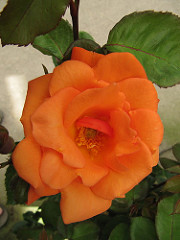

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

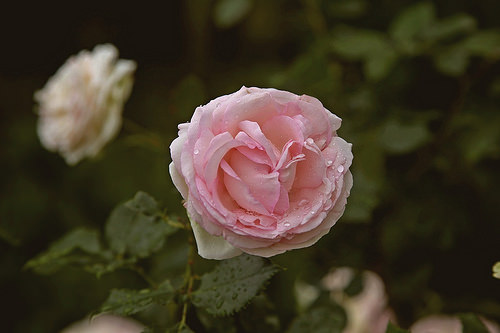

In [ ]:
rose = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

데이터셋 생성

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


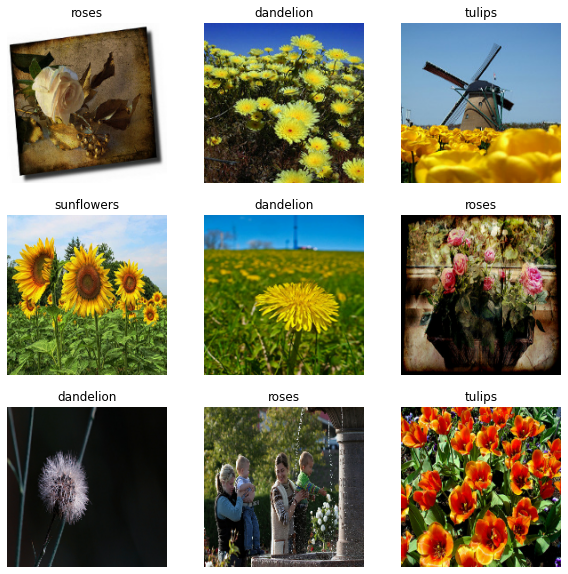

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Standardize the data( 0~255 채널 모델링 으로 나눠  0 
~1사이에 배치)


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


Configure the dataset for performance
모델 훈련

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# AUTOTUNE
# .cache()는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다(메모리에 올리기 빨리하기)
# prefetch 
#train set, validation set 학습시킬 때 cache랑 prefetch를 쓸 수 있음
#prefetch가 오히려 gpu,메모리가 딸릴 수가 있다.(out of memory 에러가 뜰 수 있음, 그럴때는 없애기)


https://ichi.pro/ko/tf-dataleul-sayonghayeo-dib-leoning-model-ui-hunlyeon-sigan-eul-jul-ineun-bangbeob-74636207139169

Train a model

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

logit은 입력값이 Sigmoid나 softmax처럼 한정된 범위로 normalization 되었는냐를 의미하는 것임, 여기서는 정규화를 시행했으니 true로 설정


sparse categorical cross entropy는 위의 labels가 One Hot Encoding이 아니라서 Sparse가 붙었다




In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 38s 68ms/step - loss: 1.2717 - accuracy: 0.4571 - val_loss: 1.0962 - val_accuracy: 0.5640
Epoch 2/3
92/92 [==============================] - 2s 23ms/step - loss: 1.0314 - accuracy: 0.5909 - val_loss: 0.9618 - val_accuracy: 0.6308
Epoch 3/3
92/92 [==============================] - 2s 22ms/step - loss: 0.8696 - accuracy: 0.6594 - val_loss: 0.9216 - val_accuracy: 0.6580


Using tf.data for finer contro

flowers_photos/
  - daisy/
  - dandelion/
  - roses/
  - sunflowers/
  - tulips/
  

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
#*는 전체를 가져오라는 뜻

In [ ]:
image_count

3670

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/3533075436_0954145b9f_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/140951103_69847c0b7c.jpg'
b'/root/.keras/datasets/flower_photos/tulips/16907559551_05ded87fb2_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/13910028149_6c9d5485ef.jpg'
b'/root/.keras/datasets/flower_photos/daisy/813445367_187ecf080a_n.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
#take:가져오는 것  

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


file path를 (img,label)형태로 만들어주는 함수를 만들어줌

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
for f in list_ds.take(5):
  parts = tf.strings.split(f, os.path.sep)
  one_hot = parts[-2] == class_names
  print(one_hot)

tf.Tensor([False  True False False False], shape=(5,), dtype=bool)
tf.Tensor([False  True False False False], shape=(5,), dtype=bool)
tf.Tensor([False False False False  True], shape=(5,), dtype=bool)
tf.Tensor([False False False False  True], shape=(5,), dtype=bool)
tf.Tensor([ True False False False False], shape=(5,), dtype=bool)


In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)# 이미지를 tensor로 바꿔줌
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

map을 이용해 image,label쌍으로 이루어진 데이터셋 생성/  process_path 함수에 train_ds,val_ds를 iteration함 num_parallel_calls는 여러 개의 스레드로 나누어 연산을 진행한다는 뜻

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

TypeError: ignored

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


우리가 원하는 것
- 이미지가 잘 섞이기
- 배치가 될 것
- 배치는 연산 가능한 만큼 할당되 효율적으로 돌아갈 것

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

- prefetch는 데이터셋이 일정한 배치를 미리 준비하도록 만들어 주는 역할을 한다
알고리즘이 훈동 등의 작업을수행하는 동안 동기에 다음 작업을 수행할 배치를 준비하여 효율을 향상 시키는 것임
- buffer_size:데이터 셋 객체의 셔플 함수에 사용되는 것인데, 데이터셋의 원소 개수보다 크거나 같아야 셔플이 원활하게 이루어진다
- autotune은 작동하는 network가 스스로 판단하여 작업을 수행할 수 있게 만들어 준다는 의미

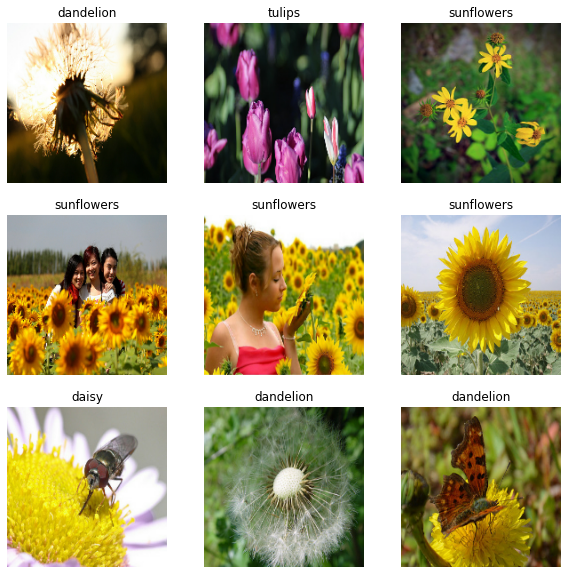

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)#1~9그려질수있게 i+1로 해줌
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 10s 94ms/step - loss: 0.7437 - accuracy: 0.7214 - val_loss: 0.7537 - val_accuracy: 0.7071
Epoch 2/3
92/92 [==============================] - 2s 26ms/step - loss: 0.5524 - accuracy: 0.7977 - val_loss: 0.7721 - val_accuracy: 0.6853
Epoch 3/3
92/92 [==============================] - 2s 25ms/step - loss: 0.3687 - accuracy: 0.8678 - val_loss: 0.8354 - val_accuracy: 0.7262


Using TensorFlow Datasets

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
# 이미 tensorflow에 있는 데이터를 load 하기

In [ ]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


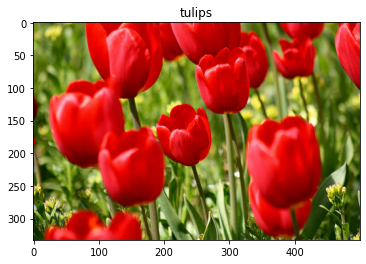

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds) #prdfetch를 사용함
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)